# Spectrum Expension

In [1]:
import yaml

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import torch

from spectrum_expension_utils import *
from inr import SphericalSiren, get_activation

In [2]:
experiences = ["Spec1", "Spec2", "Spec3"]

In [3]:
configs = {}
for experience in experiences:
    with open("configs/" + experience + ".yaml", "r") as ymlfile:
        configs[experience] = yaml.safe_load(ymlfile)

In [4]:
save_pathes = {}
model_pathes = {}

for experience in experiences:
    save_pathes[experience] = configs[experience]["EXPERIMENT_PARAMS"]["results_path"] + experience + "/"
    model_pathes[experience] = configs[experience]["EXPERIMENT_PARAMS"]["results_path"] + experience + "/model/"


In [5]:
def f(theta, phi):
    mask = phi < np.pi
    
    out = torch.zeros_like(theta)
    out[~mask] = 1.0
    return out

In [6]:
N = 1000
theta, phi = torch.meshgrid(torch.linspace(0, np.pi, N), torch.linspace(0, 2*np.pi, N), indexing='ij')

X_data = torch.stack([theta.flatten(), phi.flatten()], dim=-1)
y_data = f(theta.flatten(), phi.flatten())

In [7]:
network_params_dict = {}

for experience in experiences:

    network_params_dict[experience] = configs[experience]["NETWORK_PARAMS"]
    network_params_dict[experience]["activation"] = get_activation(network_params_dict[experience]["activation"])

In [8]:
for experience in experiences:
    print("Reachable L = K^(Q-1) x L_0 = ", 2**(network_params_dict[experience]["Q"]-1) * network_params_dict[experience]["L0"])

Reachable L = K^(Q-1) x L_0 =  20
Reachable L = K^(Q-1) x L_0 =  20
Reachable L = K^(Q-1) x L_0 =  20


In [9]:
sirens = {}

for experience in experiences:
    sirens[experience] = SphericalSiren(**network_params_dict[experience])
    sirens[experience].load_state_dict(torch.load(model_pathes[experience] + "model.pth", weights_only=True))


In [10]:
losses_train_dict ={}
losses_val_dict = {}

for experience in experiences:
    losses = torch.load(save_pathes[experience] + "losses.pth", weights_only=False)
    losses_train_dict[experience] = losses["losses_train"]
    losses_val_dict[experience] = losses["losses_val"]


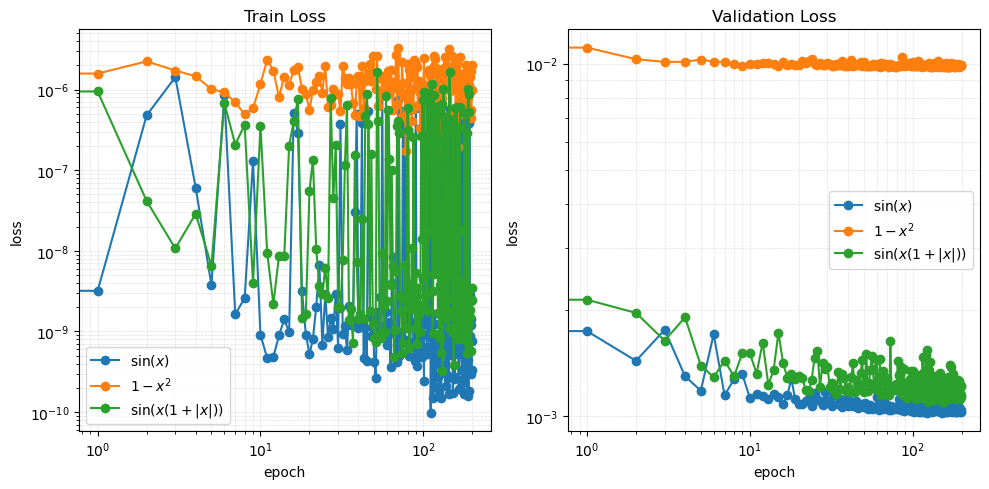

In [11]:
show_learning_curve(losses_train_dict, losses_val_dict, log=True, labels = [r"$\sin(x)$", r"$1-x^2$", r"$\sin(x(1+|x|))$"])
# show_comparisons(X_data, y_data, spherical_siren(X_data))

In [12]:
coeffs_abs_dict = {}
coeffs_inside_dict = {}

for experience in experiences:
    coeffs_abs_dict[experience] = torch.load(save_pathes[experience] + "spectrum_coeffs.pth", weights_only=False)
    coeffs_inside_dict[experience] = torch.load(save_pathes[experience] + "spectrum_coeffs_inside.pth", weights_only=False)


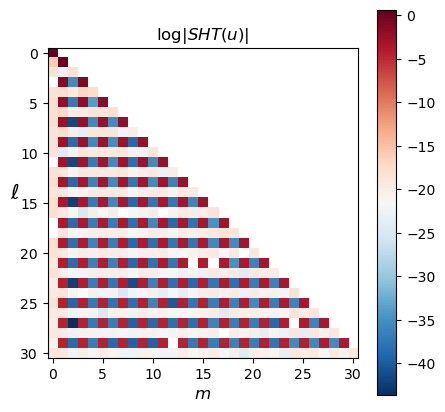

In [13]:
fig = plt.figure(figsize=(5, 5))
plt.imshow(coeffs_abs_dict[experiences[0]].log(), cmap="RdBu_r")
plt.xlabel(r"$m$", fontsize = 12)
plt.ylabel(r"$\ell$", rotation= 0 , fontsize = 15)
plt.title("$\log | SHT(u) |$")
plt.colorbar()
plt.show()

1e-06 0.5780932307243347


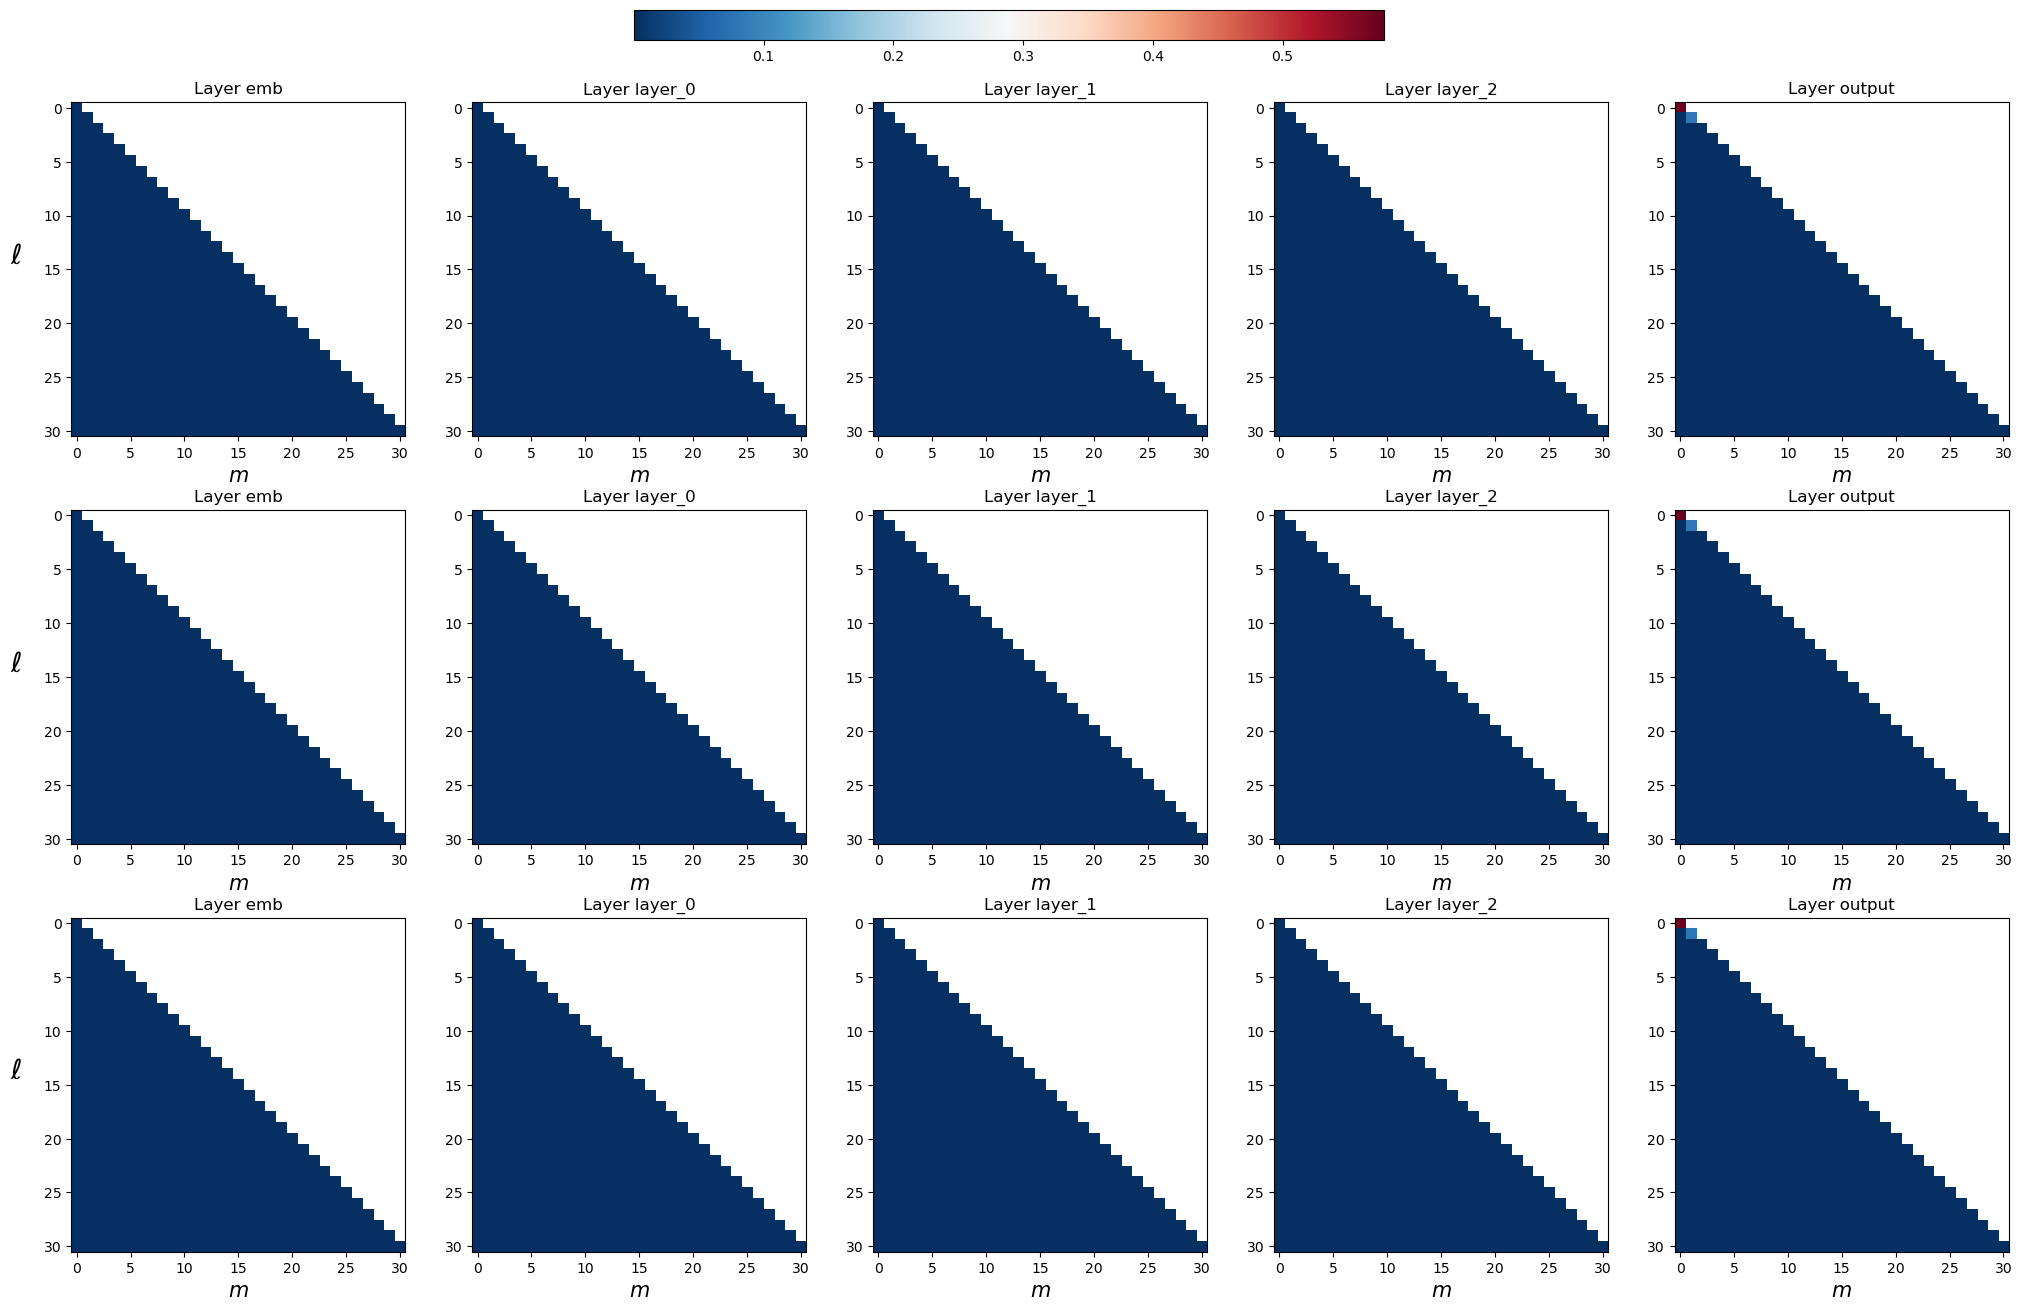

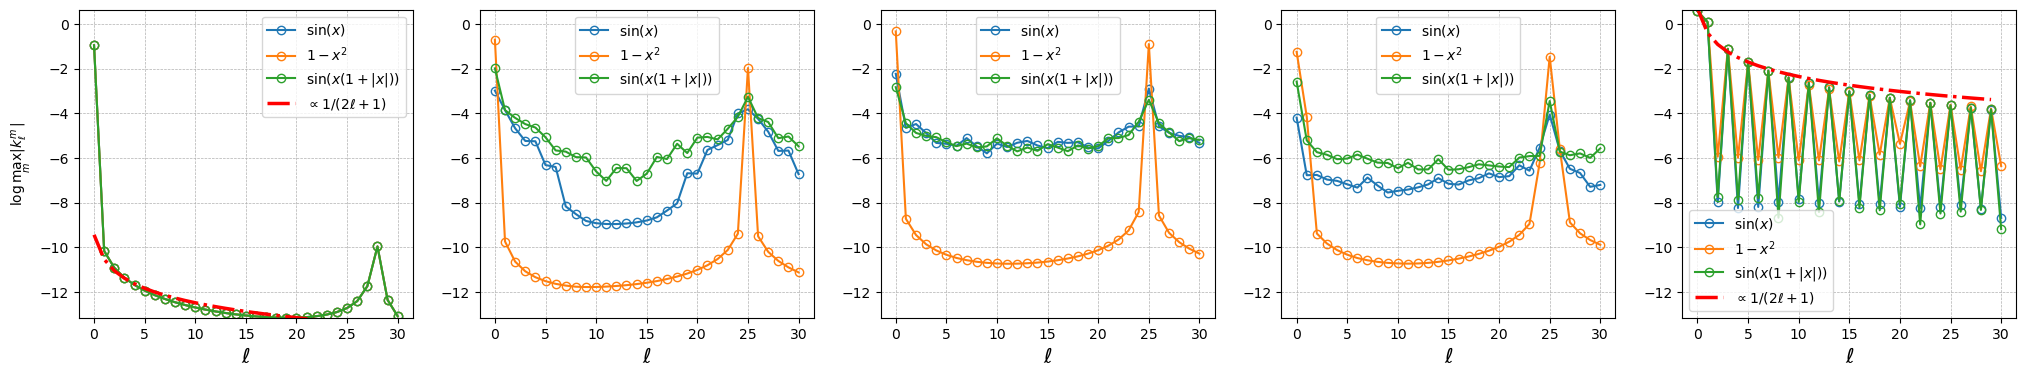

In [18]:

# Initialize the number of layers and labels
n_layers = sirens[experiences[0]].Q + 2
labels = [r"$\sin(x)$", r"$1-x^2$", r"$\sin(x(1+|x|))$"]

global_min = 1e-6
global_max = float('-inf')

# First pass to find the min and max values across all experiences and layers
for experience in experiences:
    for layer, inside in coeffs_inside_dict[experience].items():
        data = inside.abs().log()
        # global_min = min(global_min, data.min().item())
        global_max = max(global_max, data.max().item())

print(global_min, global_max)
# Create the main figure for the heatmaps
fig1, axs1 = plt.subplots(len(experiences), n_layers, figsize=(5 * n_layers, len(experiences) * 5))

# Variables for max and min coefficients
y_max_plot = 0
y_min_plot = 0

# Loop through each experience for heatmaps
for iExp, experience in enumerate(experiences):
    for i, (layer, inside) in enumerate(coeffs_inside_dict[experience].items()):
        im = axs1[iExp, i].imshow(inside.abs().log(), cmap="RdBu_r", vmin=global_min, vmax=global_max)
        axs1[iExp, i].set_title(f"Layer {layer}")
        axs1[iExp, i].set_xlabel(r"$m$", fontsize=15)
        
        # Compute max coefficients
        max_coeffs = torch.max(inside.abs(), dim=0).values.log()
        
        y_max_plot = max(y_max_plot, max_coeffs.max())  
        y_min_plot = min(y_min_plot, max_coeffs.min())

    # Set y-axis label for the first column
    axs1[iExp, 0].set_ylabel(r"$\ell$", rotation=0, fontsize=20, labelpad=20)

# Add color bar at the top
cbar_ax1 = fig1.add_axes([0.35, 0.92, 0.3, 0.02])
fig1.colorbar(im, cax=cbar_ax1, orientation='horizontal', fraction=0.01, shrink=0.1)

# Display the first figure with heatmaps
plt.show()

# Create a new figure for max coefficient plots
fig2, axs2 = plt.subplots(1, n_layers, figsize=(5 * n_layers, 4))

handles = []
labels_set = set()  # To avoid duplicate labels

# Plot max coefficients for each layer in the new figure
for iExp, experience in enumerate(experiences):
    for i, (layer, inside) in enumerate(coeffs_inside_dict[experience].items()):
        max_coeffs = torch.max(inside.abs(), dim = 0).values.log()

        line, = axs2[i].plot(max_coeffs, marker="o", fillstyle="none", label=labels[iExp])
        

        axs2[i].set_xlabel(r"$\ell$", fontsize=15)
        axs2[i].set_ylim(y_min_plot, 1.1 * y_max_plot)
        axs2[i].grid(True, which='both', linestyle='--', linewidth=0.5)

# Set y-axis label for max coefficient plot
l = np.arange(0, 30)
axs2[-1].plot(l, np.log(10**(0.3)/(2*l +1)), linestyle="-.", color="red", label=r"$\propto 1/(2\ell+1)$", linewidth=2.5)
axs2[0].plot(l, np.log(10**(-4.1)/(2*l +1)), linestyle="-.", color="red", label=r"$\propto 1/(2\ell+1)$", linewidth=2.5)
for i in range(n_layers): axs2[i].legend()


axs2[0].set_ylabel(r"$\log \max_{m} |k_{\ell}^m|$", fontsize=10)
# Display the second figure for max coefficients
plt.show()



